In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # to disable GPU
from ts_data.ts_data import ts_data as ts
import getStocks
import visualize
import ts_models.predicts
import pandas as pd
import ts_models.ts_lstm as ts_lstm

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

/home/ahendel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# view tenslow enabled devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 12031086492461024801
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


# User parameters

In [14]:
ticker = 'amd'.upper()
n_in = 100 # number of historical days to input
n_out = 10 # days into future to predict
target = 'd1close'

# Load Data
### Several methods available here:
* Load a single stock
* get a refresh of the stock
* load a single stock as the target while using many other stocks as additional features

## Pick the Sector and/or Industry

Purpose is to come up with a list of tickers and their corresponding exchange

In [15]:
#d=getStocks.get_tickers_industry()
#d.to_csv('tickers_w_industry.csv')

In [16]:
import imp
imp.reload(getStocks)

Join resulted in 2112 complete records.


In [5]:
# load dataset
# dataset = getStocks.get_single(ticker=ticker, save=True)
# dataset = getStocks.load_single(ticker)
dataset = getStocks.join_tgt_spt(target_ticker=ticker.upper(), industry=['Semiconductors'], exclude=['MU','QRVO'])
# dataset.reset_index(level=0, inplace=True, drop=True)
dataset.rename(columns=lambda x: x.replace(' ',''),inplace=True)

In [6]:
dataset.head()

,Date,Open,High,Low,Close,AdjClose,Volume,MOpen,MHigh,MLow,MClose,MAdjClose,MVolume,HBIOpen,HBIHigh,HBILow,HBIClose,HBIAdjClose,HBIVolume,BKOpen,BKHigh,BKLow,BKClose,BKAdjClose,BKVolume,VIABOpen,VIABHigh,VIABLow,VIABClose,VIABAdjClose,VIABVolume,MGMOpen,MGMHigh,MGMLow,MGMClose,MGMAdjClose,MGMVolume,MTBOpen,MTBHigh,MTBLow,MTBClose,MTBAdjClose,MTBVolume,EMNOpen,EMNHigh,EMNLow,EMNClose,EMNAdjClose,EMNVolume,CELGOpen,CELGHigh,CELGLow,CELGClose,CELGAdjClose,CELGVolume,IPOpen,IPHigh,IPLow,IPClose,IPAdjClose,IPVolume,TXNOpen,TXNHigh,TXNLow,TXNClose,TXNAdjClose,TXNVolume,APCOpen,APCHigh,APCLow,APCClose,APCAdjClose,APCVolume,ULTAOpen,ULTAHigh,ULTALow,ULTAClose,ULTAAdjClose,ULTAVolume,HSICOpen,HSICHigh,HSICLow,HSICClose,HSICAdjClose,HSICVolume,DOpen,DHigh,DLow,DClose,DAdjClose,DVolume,ABCOpen,ABCHigh,ABCLow,ABCClose,ABCAdjClose,ABCVolume,COpen,CHigh,CLow,CClose,CAdjClose,CVolume,CTASOpen,CTASHigh,CTASLow,CTASClose,CTASAdjClose,CTASVolume,ACNOpen,ACNHigh,ACNLow,ACNClose,ACNAdjClose,ACNVolume,TROWOpen,TROWHigh,TROWLow,TROWClose,TROWAdjClose,TROWVolume,CTLOpen,CTLHigh,CTLLow,CTLClose,CTLAdjClose,CTLVolume
0,1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.153107,9.461292,9.122288,9.430473,1.792621,71700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1970-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.584566,9.861933,9.584566,9.769477,1.857062,118400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1970-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.769477,9.800296,9.615385,9.677022,1.839488,84300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1970-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.646203,9.646203,9.399654,9.461292,1.798479,93600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1970-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.492110,9.584566,9.492110,9.553747,1.816054,74200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare Data for LSTM

In [17]:
ts_data = ts(n_in=n_in, 
             n_out=n_out, 
             ticker=ticker,
             target=target,
             rawData=dataset)

In [18]:
ts_data.eng_features(derivate=True, weekdays=False)

/media/ahendel/Data/Dropbox/Projects/forecast-engine/src/ts_data/ts_data.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data.drop('Date', axis=1, inplace=True)


In [19]:
ts_data.roll_data()

Total Supervised Learning Records: 2001


In [20]:
ts_data.tscv(train=0.98)

In [21]:
ts_data.data.tail()

,Open(t-100),High(t-100),Low(t-100),Close(t-100),AdjClose(t-100),Volume(t-100),OpenAMD(t-100),HighAMD(t-100),LowAMD(t-100),CloseAMD(t-100),AdjCloseAMD(t-100),VolumeAMD(t-100),OpenADI(t-100),HighADI(t-100),LowADI(t-100),CloseADI(t-100),AdjCloseADI(t-100),VolumeADI(t-100),OpenAMAT(t-100),HighAMAT(t-100),LowAMAT(t-100),CloseAMAT(t-100),AdjCloseAMAT(t-100),VolumeAMAT(t-100),OpenAVGO(t-100),HighAVGO(t-100),LowAVGO(t-100),CloseAVGO(t-100),AdjCloseAVGO(t-100),VolumeAVGO(t-100),OpenINTC(t-100),HighINTC(t-100),LowINTC(t-100),CloseINTC(t-100),AdjCloseINTC(t-100),VolumeINTC(t-100),OpenMCHP(t-100),HighMCHP(t-100),LowMCHP(t-100),CloseMCHP(t-100),AdjCloseMCHP(t-100),VolumeMCHP(t-100),OpenNVDA(t-100),HighNVDA(t-100),LowNVDA(t-100),CloseNVDA(t-100),AdjCloseNVDA(t-100),VolumeNVDA(t-100),OpenSWKS(t-100),HighSWKS(t-100),LowSWKS(t-100),CloseSWKS(t-100),AdjCloseSWKS(t-100),VolumeSWKS(t-100),OpenTXN(t-100),HighTXN(t-100),LowTXN(t-100),CloseTXN(t-100),AdjCloseTXN(t-100),VolumeTXN(t-100),OpenXLNX(t-100),HighXLNX(t-100),LowXLNX(t-100),CloseXLNX(t-100),AdjCloseXLNX(t-100),VolumeXLNX(t-100),d2close(t-100),d1vol(t-100),d2vol(t-100),d1close(t-100),Open(t-99),High(t-99),Low(t-99),Close(t-99),AdjClose(t-99),Volume(t-99),OpenAMD(t-99),HighAMD(t-99),LowAMD(t-99),CloseAMD(t-99),AdjCloseAMD(t-99),VolumeAMD(t-99),OpenADI(t-99),HighADI(t-99),LowADI(t-99),CloseADI(t-99),AdjCloseADI(t-99),VolumeADI(t-99),OpenAMAT(t-99),HighAMAT(t-99),LowAMAT(t-99),CloseAMAT(t-99),AdjCloseAMAT(t-99),VolumeAMAT(t-99),OpenAVGO(t-99),HighAVGO(t-99),LowAVGO(t-99),CloseAVGO(t-99),AdjCloseAVGO(t-99),VolumeAVGO(t-99),OpenINTC(t-99),HighINTC(t-99),LowINTC(t-99),CloseINTC(t-99),AdjCloseINTC(t-99),VolumeINTC(t-99),OpenMCHP(t-99),HighMCHP(t-99),LowMCHP(t-99),CloseMCHP(t-99),AdjCloseMCHP(t-99),VolumeMCHP(t-99),OpenNVDA(t-99),HighNVDA(t-99),LowNVDA(t-99),CloseNVDA(t-99),AdjCloseNVDA(t-99),VolumeNVDA(t-99),OpenSWKS(t-99),HighSWKS(t-99),LowSWKS(t-99),CloseSWKS(t-99),AdjCloseSWKS(t-99),VolumeSWKS(t-99),OpenTXN(t-99),HighTXN(t-99),LowTXN(t-99),CloseTXN(t-99),AdjCloseTXN(t-99),VolumeTXN(t-99),OpenXLNX(t-99),HighXLNX(t-99),LowXLNX(t-99),CloseXLNX(t-99),AdjCloseXLNX(t-99),VolumeXLNX(t-99),d2close(t-99),d1vol(t-99),d2vol(t-99),d1close(t-99),Open(t-98),High(t-98),Low(t-98),Close(t-98),AdjClose(t-98),Volume(t-98),OpenAMD(t-98),HighAMD(t-98),LowAMD(t-98),CloseAMD(t-98),AdjCloseAMD(t-98),VolumeAMD(t-98),OpenADI(t-98),HighADI(t-98),LowADI(t-98),CloseADI(t-98),AdjCloseADI(t-98),VolumeADI(t-98),OpenAMAT(t-98),HighAMAT(t-98),LowAMAT(t-98),CloseAMAT(t-98),AdjCloseAMAT(t-98),VolumeAMAT(t-98),OpenAVGO(t-98),HighAVGO(t-98),LowAVGO(t-98),CloseAVGO(t-98),AdjCloseAVGO(t-98),VolumeAVGO(t-98),OpenINTC(t-98),HighINTC(t-98),LowINTC(t-98),CloseINTC(t-98),AdjCloseINTC(t-98),VolumeINTC(t-98),OpenMCHP(t-98),HighMCHP(t-98),LowMCHP(t-98),CloseMCHP(t-98),AdjCloseMCHP(t-98),VolumeMCHP(t-98),OpenNVDA(t-98),HighNVDA(t-98),LowNVDA(t-98),CloseNVDA(t-98),AdjCloseNVDA(t-98),VolumeNVDA(t-98),OpenSWKS(t-98),HighSWKS(t-98),LowSWKS(t-98),CloseSWKS(t-98),AdjCloseSWKS(t-98),VolumeSWKS(t-98),OpenTXN(t-98),HighTXN(t-98),LowTXN(t-98),CloseTXN(t-98),AdjCloseTXN(t-98),VolumeTXN(t-98),OpenXLNX(t-98),HighXLNX(t-98),LowXLNX(t-98),CloseXLNX(t-98),AdjCloseXLNX(t-98),VolumeXLNX(t-98),d2close(t-98),d1vol(t-98),d2vol(t-98),d1close(t-98),Open(t-97),High(t-97),Low(t-97),Close(t-97),AdjClose(t-97),Volume(t-97),OpenAMD(t-97),HighAMD(t-97),LowAMD(t-97),CloseAMD(t-97),AdjCloseAMD(t-97),VolumeAMD(t-97),OpenADI(t-97),HighADI(t-97),LowADI(t-97),CloseADI(t-97),AdjCloseADI(t-97),VolumeADI(t-97),OpenAMAT(t-97),HighAMAT(t-97),LowAMAT(t-97),CloseAMAT(t-97),AdjCloseAMAT(t-97),VolumeAMAT(t-97),OpenAVGO(t-97),HighAVGO(t-97),LowAVGO(t-97),CloseAVGO(t-97),AdjCloseAVGO(t-97),VolumeAVGO(t-97),OpenINTC(t-97),HighINTC(t-97),LowINTC(t-97),CloseINTC(t-97),AdjCloseINTC(t-97),VolumeINTC(t-97),OpenMCHP(t-97),HighMCHP(t-97),LowMCHP(t-97),CloseMCHP(t-97),AdjCloseMCHP(t-97),VolumeMCHP(t-97),OpenNVDA(t-97),HighNVDA(t-97),LowNVDA(t-97),CloseNVDA(t-97),AdjCloseNVDA(t-97),VolumeNVDA(t-97)

# Build LSTM Architecture

In [22]:
ts_model = ts_lstm.lstm_model(ts_data, 
                               inlayer=int(ts_data.train_X.shape[-1])*2,
                               hiddenlayers=0,
                               loss_function='mean_squared_error',
                               dropout=0.05,
                               activation='tanh',
                               gpus=1)

Compilation Time :  0.011874675750732422
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 140)               118160    
_________________________________________________________________
dropout_2 (Dropout)          (None, 140)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1410      
Total params: 119,570
Trainable params: 119,570
Non-trainable params: 0
_________________________________________________________________


# Fit model

In [23]:
import time
start = time.time()
history = ts_model.fit(ts_data.train_X, ts_data.train_y, 
                    epochs=50, 
                    batch_size=1024, 
                    validation_data=(ts_data.test_X, ts_data.test_y), 
                    verbose=2, 
                    shuffle=False)
fitTime = time.time()-start
print('Fit Time: {}'.format(round(fitTime,2)))

Train on 1960 samples, validate on 41 samples
Epoch 1/50
 - 1s - loss: 0.5866 - val_loss: 0.5857
Epoch 2/50
 - 0s - loss: 0.5368 - val_loss: 0.5467
Epoch 3/50
 - 0s - loss: 0.4902 - val_loss: 0.5107
Epoch 4/50
 - 0s - loss: 0.4458 - val_loss: 0.4788
Epoch 5/50
 - 0s - loss: 0.4063 - val_loss: 0.4512
Epoch 6/50
 - 0s - loss: 0.3727 - val_loss: 0.4275
Epoch 7/50
 - 0s - loss: 0.3449 - val_loss: 0.4075
Epoch 8/50
 - 0s - loss: 0.3160 - val_loss: 0.3905
Epoch 9/50
 - 0s - loss: 0.2971 - val_loss: 0.3763
Epoch 10/50
 - 0s - loss: 0.2774 - val_loss: 0.3643
Epoch 11/50
 - 0s - loss: 0.2613 - val_loss: 0.3542
Epoch 12/50
 - 0s - loss: 0.2482 - val_loss: 0.3454
Epoch 13/50
 - 0s - loss: 0.2371 - val_loss: 0.3376
Epoch 14/50
 - 0s - loss: 0.2254 - val_loss: 0.3306
Epoch 15/50
 - 0s - loss: 0.2167 - val_loss: 0.3241
Epoch 16/50
 - 0s - loss: 0.2096 - val_loss: 0.3181
Epoch 17/50
 - 0s - loss: 0.2032 - val_loss: 0.3124
Epoch 18/50
 - 0s - loss: 0.1956 - val_loss: 0.3071
Epoch 19/50
 - 0s - loss: 0

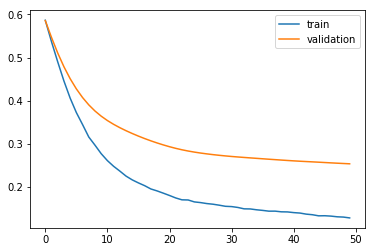

In [24]:
visualize.plot_loss(history)

# Results

In [25]:
# select last 30 days of test data (30 records)
n = 30
test_X = ts_data.test_X[-n:]
test_Y = ts_data.test_y[-n:]

In [32]:
yhat = [ts_model.predict(x.reshape(1, test_X.shape[-2], test_X.shape[-1])) for x in test_X]

array([ 0.13 , -0.04 ,  0.06 , -0.03 ,  0.01 ,  0.17 , -0.38 , -0.34 ,
        0.06 , -0.16 , -0.7  , -0.12 ,  0.09 ,  0.04 , -0.1  ,  0.22 ,
       -0.26 ,  0.21 ,  0.02 ,  0.16 ,  0.69 , -0.03 ,  0.03 , -0.09 ,
       -0.445])

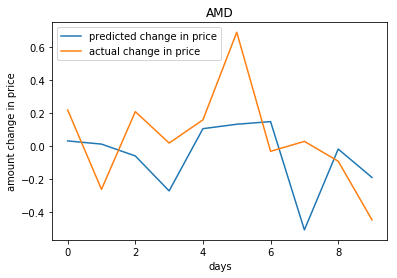

In [54]:
yhat = [float(ts_model.predict(x.reshape(1, test_X.shape[-2], test_X.shape[-1]))) for x in test_X]

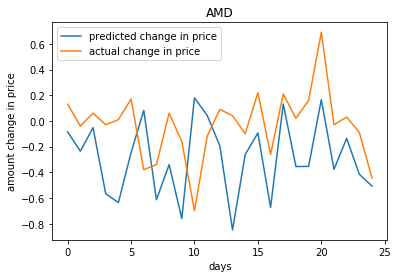

In [16]:
import matplotlib.pyplot as plt
x = [x for x in range(len(yhat[-1][0]))]
plt.plot(x, yhat[-1][0], label='predicted change in price')
plt.plot(x, test_Y[-1], label='actual change in price')
plt.title(ticker)
plt.xlabel('days')
plt.ylabel('amount change in price')
plt.legend()
plt.show()